In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# Create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# Reflect an existing database into a new model
Base = automap_base()
# Reflect the tables
Base.prepare(autoload_with=engine)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table

# Assign measurement class to variable called 'measurement'
measurement = Base.classes.measurement

# Assign station class to variable called 'station'
station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
recent_date_data = session.query(func.max(measurement.date)).all()
for row in recent_date_data:
    recent_date = row[0]
    print(recent_date)

2017-08-23


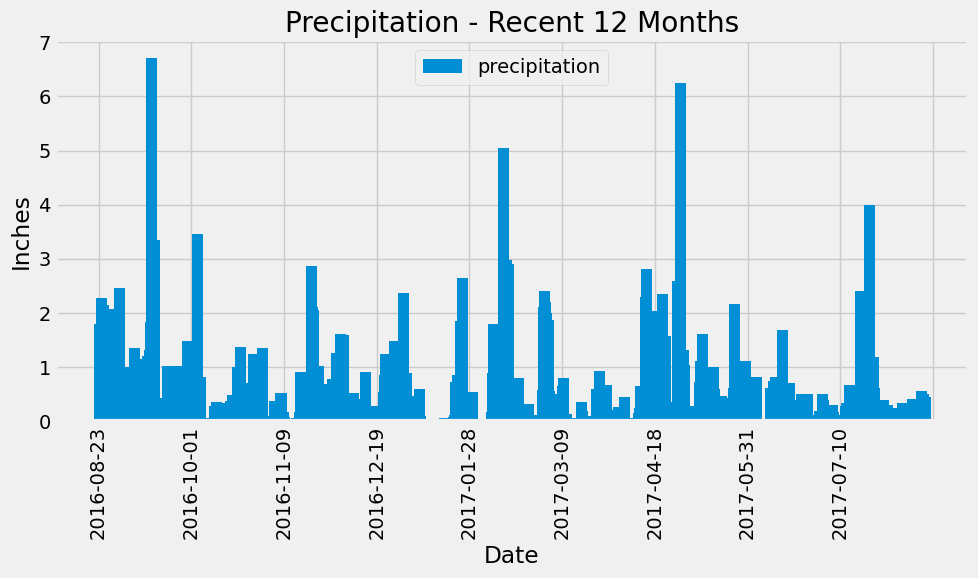

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
most_recent_date = dt.datetime.strptime(recent_date, '%Y-%m-%d').date()
# Calculate the date one year from the last date in data set.
one_year_prior_date = most_recent_date - dt.timedelta(days=365)
# Perform a query to retrieve the data and precipitation scores
data = session.query(measurement.date, measurement.prcp).filter(measurement.date >= one_year_prior_date).all()
# Save the query results as a Pandas DataFrame. Explicitly set the column names
data_db = pd.DataFrame(data, columns=['date', 'precipitation'])
# Sort the dataframe by date
data_db = data_db.sort_values('date', ascending=True)

# Use Pandas Plotting with Matplotlib to plot the data
precip_graph = data_db.plot(kind='bar', legend=True, figsize=(10, 6), x='date', y='precipitation', width=30)
# Determine max and min values of the x-axis and then redefine the xlim to add some additional padding
x_min,x_max = precip_graph.get_xlim()
plt.xlim(x_min-100, x_max+100)
# Reset the number of tick labels that appear on the x-axis so as not to crowd the chart with every x-axis values
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(10))
# Set location of legend
plt.legend(loc='upper center')
# Add a title and label the axes
plt.title("Precipitation - Recent 12 Months")
plt.xlabel("Date")
plt.ylabel("Inches")
plt.tight_layout()
plt.show()





In [11]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_stats = pd.DataFrame(data_db['precipitation'].describe())
summary_stats

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [12]:
# Design a query to calculate the total number of stations in the dataset
num_stations = session.query(station.station).distinct().count()
print(num_stations)

9


In [13]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
station_counts = session.query(measurement.station, func.count(measurement.station)).group_by(measurement.station).order_by(func.count(measurement.station).desc()).all()
for row in station_counts:
    print(row)

('USC00519281', 2772)
('USC00519397', 2724)
('USC00513117', 2709)
('USC00519523', 2669)
('USC00516128', 2612)
('USC00514830', 2202)
('USC00511918', 1979)
('USC00517948', 1372)
('USC00518838', 511)


In [14]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
# Since 'station_counts' is in descending order we know that the first item is the most active station based on counts so we can save it as a variable 'most_active-station_id'
most_active_station_id = station_counts[0][0]
# Query the min, max, and average tobs by filtering the data based on the station id stored in 'most_active_station_id
active_station_temps = session.query(func.min(measurement.tobs), func.max(measurement.tobs), func.avg(measurement.tobs)).filter(measurement.station == most_active_station_id).all()
# Loop through the query results and store it as a list to be displayed
[temp for temp in active_station_temps]

[(54.0, 85.0, 71.66378066378067)]

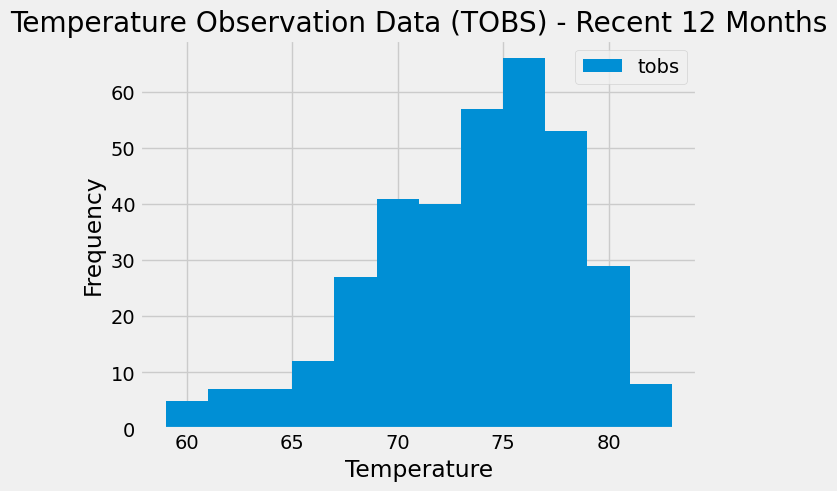

In [15]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
last_12month_tobs = session.query(measurement.tobs).filter(measurement.station == most_active_station_id).filter(measurement.date >= one_year_prior_date).all()
# Store the query as a pandas DataFrame and then plot as a histogram
last_12month_tobs_df = pd.DataFrame(last_12month_tobs)
last_12month_tobs_df.plot(kind='hist', bins=12)
# Add a title and label the x-axis
plt.xlabel('Temperature')
plt.title('Temperature Observation Data (TOBS) - Recent 12 Months')
plt.show()

# Close Session

In [16]:
# Close Session
session.close()